# Automated analysis of optical fundus images


In [1]:
import numpy as np
import scipy.ndimage.filters
import skimage.filters as filters
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import clear_border
from skimage import io, img_as_int
from skimage import data, color, exposure, segmentation
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.transform import hough_line, hough_line_peaks, hough_circle, hough_circle_peaks, probabilistic_hough_line
from skimage import feature
from skimage.morphology import binary_dilation, binary_erosion, medial_axis

from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte, img_as_float, crop
from scipy import ndimage as ndi
from skimage.morphology import dilation, erosion, disk, rectangle, opening, closing, thin, reconstruction, extrema, binary_closing, binary_opening, watershed
from skimage.filters import rank, threshold_otsu, meijering
from skimage import util
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import label, regionprops
import matplotlib.patches as patches
from skimage.morphology import remove_small_objects
from skimage import measure
from scipy import signal
from sklearn.metrics import jaccard_score

## Subtask 2.1 Extracting vessels from raw fundus images
#### Subtask 2.1.1:  Load your image and crop it from y = 1 and x = 1001 for a height of 800 pixels and a width of 2500. E.g the input for crop rectangle tuple of ((x,y,x+width,y+height) would be ((1001,1,2500,800)).

Text(0.5, 1.0, 'Cropped image')

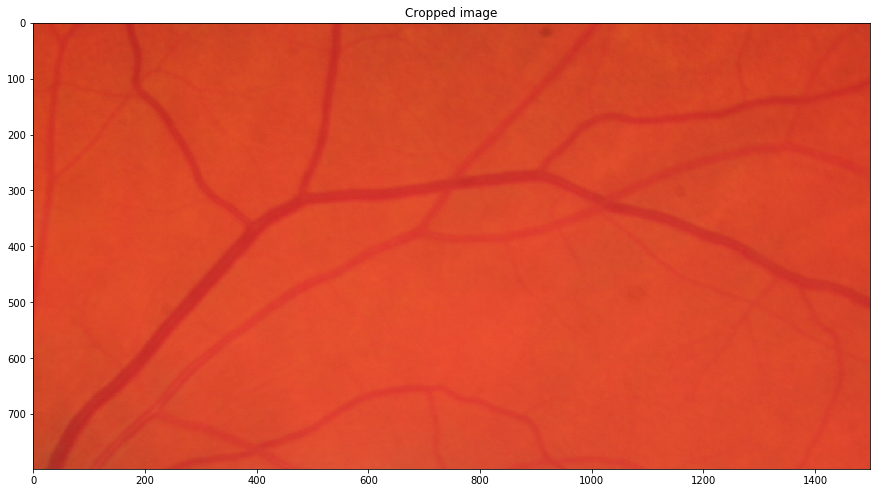

In [2]:
input = Image.open('img_04_g.jpg')
temp = input.crop((1001,1,2500,800))
image = np.asarray(temp)

comp_input = Image.open('manual_04_g.tif')
comp_temp = comp_input.crop((1001,1,2500,800))
comp = np.asarray(comp_temp)

plt.figure(figsize=(15,10))
plt.imshow(image)
plt.title('Cropped image')

#### Subtask 2.1.2:  You will write code to segment vessels in the cropped fundus image. Your solution do not have to be limited to simply applying standard image analysis techniques. The binary image is the manual annotation results. Compare the accuracy of your segmentation solution with this binary image. A detailed mark breakdown will be provided later this week.

C:\Users\Generic\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


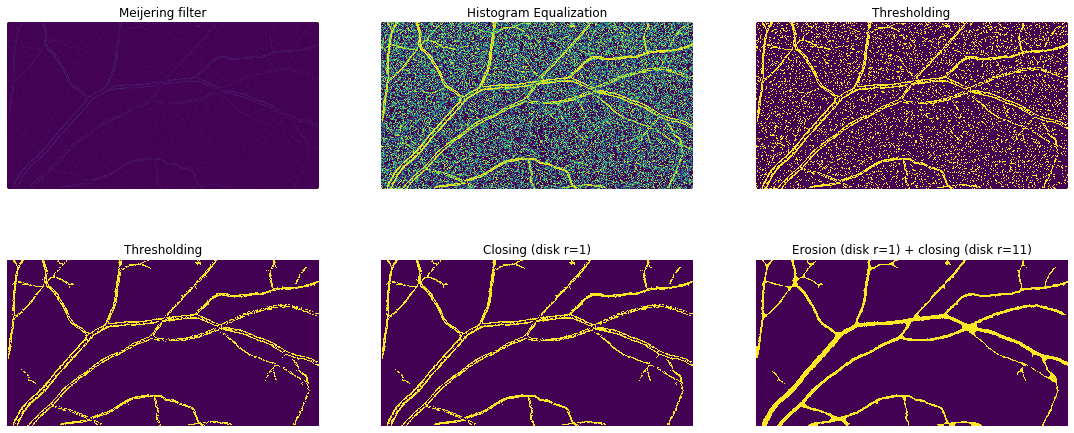

In [3]:
im = color.rgb2gray(image)
im = rank.median(im, disk(5))
RFImage = meijering(im, black_ridges=True, sigmas=[1])
plt.figure(figsize=(19,8))

plt.subplot(231)
plt.imshow(RFImage)
plt.title("Meijering filter")
plt.axis('off')

RFImage = exposure.equalize_hist(RFImage)
plt.subplot(232)
plt.imshow(RFImage)
plt.title('Histogram Equalization')
plt.axis('off')


RFImage = RFImage > 0.85

plt.subplot(233)
plt.imshow(RFImage)
plt.title('Thresholding')
plt.axis('off')

RFImage = remove_small_objects(RFImage, 300, connectivity=1)
plt.subplot(234)
plt.imshow(RFImage)
plt.title('Thresholding')
plt.axis('off')

RFImage = binary_closing(RFImage, disk(1))
plt.subplot(235)
plt.imshow(RFImage)
plt.title('Closing (disk r=1)')
plt.axis('off')

RFImage = binary_erosion(RFImage, disk(1))
RFImage = binary_closing(RFImage, disk(11))

plt.subplot(236)
plt.imshow(RFImage)
plt.title('Erosion (disk r=1) + closing (disk r=11)')
plt.axis('off')

RFImage[RFImage == True] = 1
RFImage[RFImage == False] = 0

0.6640536750569018

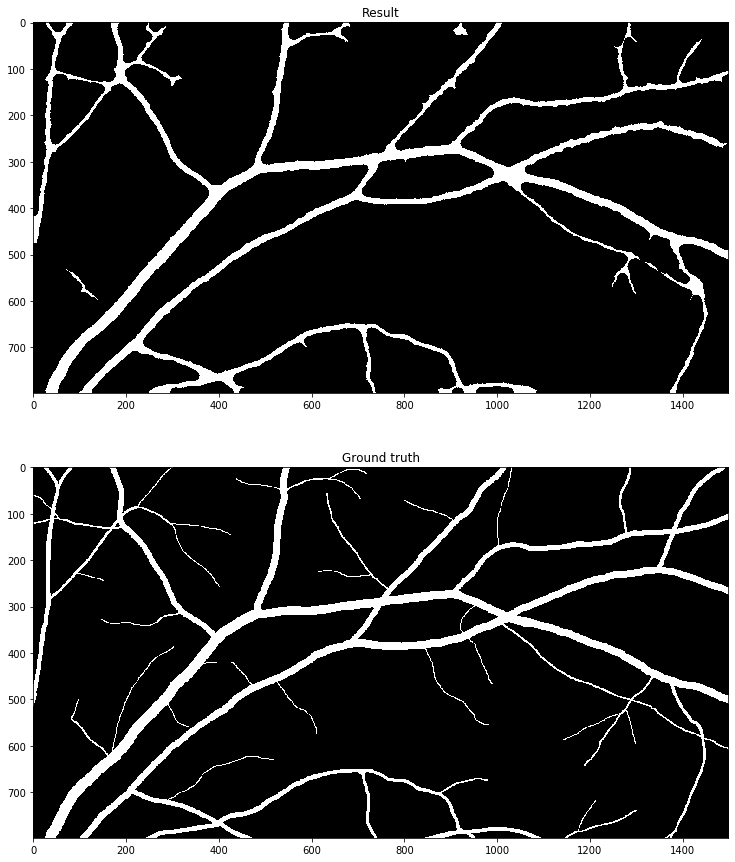

In [4]:
plt.figure(figsize=(15,15))
plt.subplot(211), plt.imshow(RFImage, cmap='gray'), plt.title('Result')
plt.subplot(212), plt.imshow(comp, cmap='gray'), plt.title('Ground truth')

jaccard_score(comp, RFImage, labels=None, pos_label=1, average='weighted', sample_weight=None)

##  Task 2.2 Processing a binary image of segmented vessels
#### Subtask 2.2.1. Remove small vessels (less than 8 pixels wide) with morphological opening.



Text(0.5, 1.0, 'Small vessels removed')

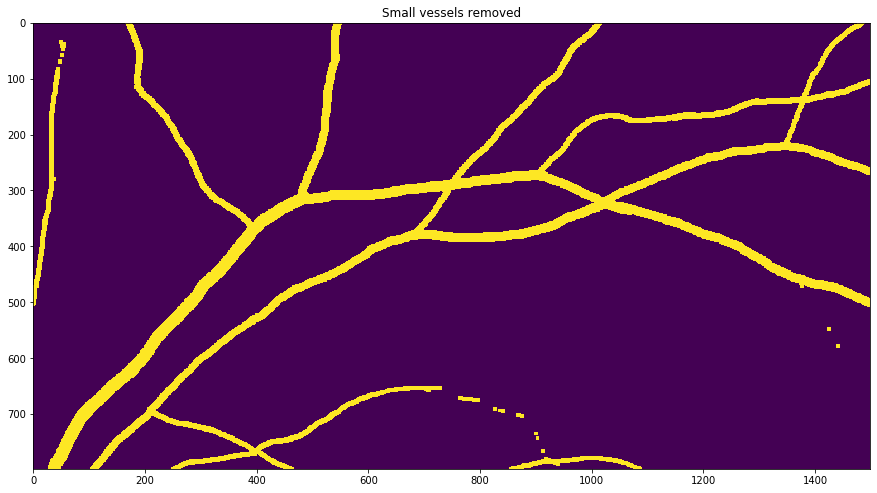

In [5]:
comp_input = Image.open('manual_04_g.tif')
comp_temp = comp_input.crop((1001,1,2500,800))
comp = np.asarray(comp_temp)

big_vessels = binary_opening(comp, rectangle(7, 7))

plt.figure(figsize=(15, 15))
plt.imshow(big_vessels)
plt.title('Small vessels removed')

#### Subtask 2.2.2. Apply morphological thinning to obtain a 1 pixel thin centerline of the vascular network. Apply a medial axis transforms to compute the width of the vessel for the pixels of the skeleton.


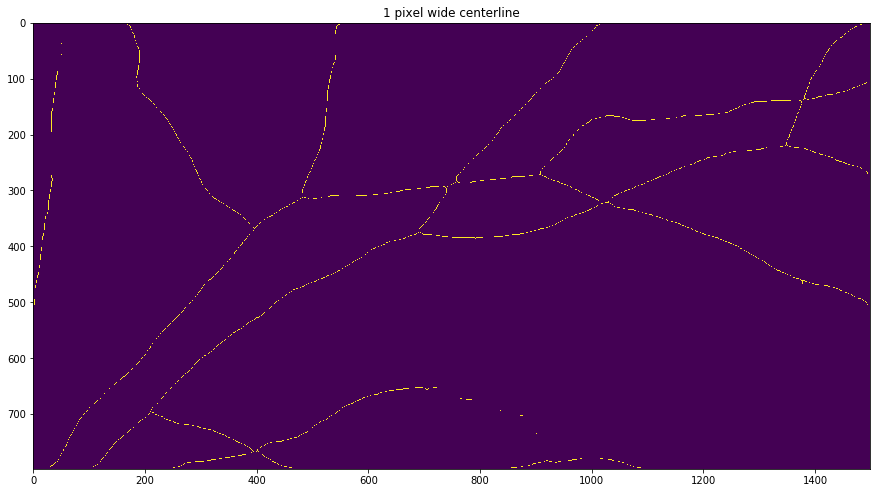

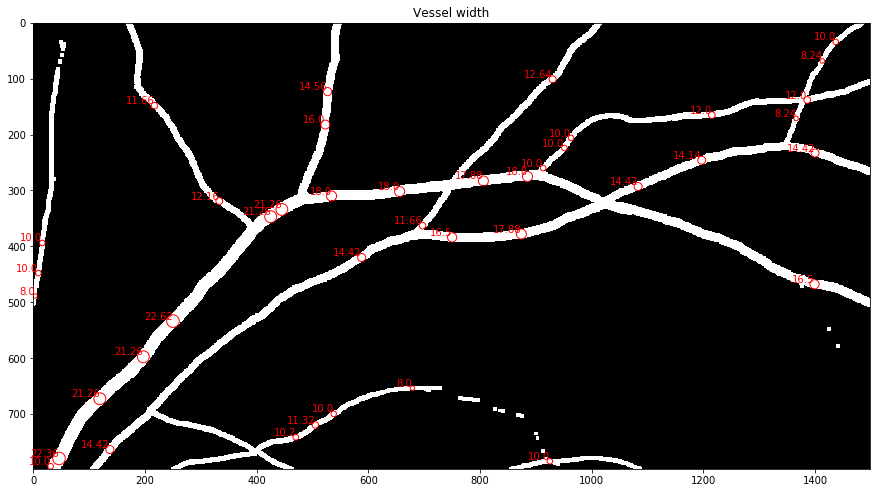

In [6]:
thinned = thin(big_vessels)

plt.figure(figsize=(15, 15))
plt.imshow(thinned)
plt.title("1 pixel wide centerline")
count = 0

skel, distance = medial_axis(big_vessels, return_distance=True)

figure, axis = plt.subplots(1, figsize=(15, 15))
axis.imshow(big_vessels, cmap=plt.cm.gray)
plt.title("Vessel width")

distance_mask = np.invert(thin(distance))
distance[distance_mask] = 0

for x, row in enumerate(distance):
    for y, dist in enumerate(row):
        if dist > 0:
            if count > 150:
                shape = patches.Circle((y, x), round(dist, 2), facecolor='none', edgecolor='red')
                axis.add_patch(shape)
                axis.text(y, x, round(dist, 2)*2,
                        color='red',
                        horizontalalignment='right',
                        verticalalignment='bottom')
                count = 0
            else: 
                count += 1


#### Sutask 2.2.3. Find length and orientation of the vascular network in the image after thining. Display the orientation distribution of the vascular network in a polar (rose) plot.

Length of vascular system:  6260


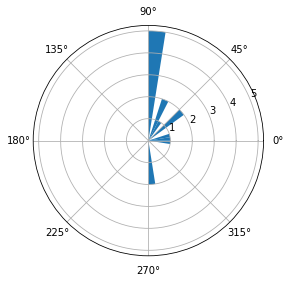

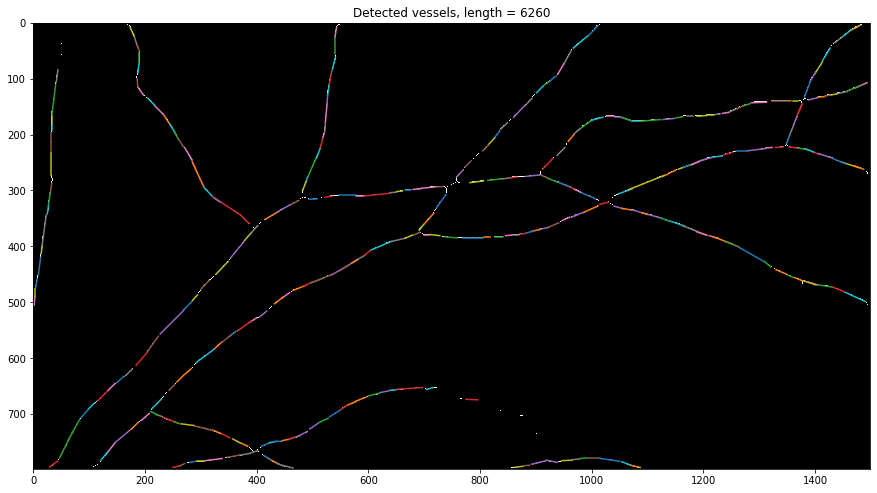

In [7]:
from scipy.spatial import distance

im = img_as_ubyte(thinned)
N = 20

# Hough transforms to find lines
H, theta, rho = hough_line(im);
hspace, angles, dists = hough_line_peaks(H, theta, rho)

# Display orientation
fig = plt.figure()
fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

radii = np.histogram(angles, bins=20)
atheta = np.arange(-np.pi/2, np.pi/2, np.pi/N)

width = np.pi/N
plt.bar(atheta+np.pi/(2*N), radii[0], width=width, bottom=0.0)

# Probabilistic hough transform     
lines = probabilistic_hough_line(im, threshold=1, line_length=10, line_gap=2)
system_length = 0

# display results 
plt.figure(figsize=(15,15))
plt.imshow(im, cmap='gray')

for line in lines:
    p0, p1 = line
    system_length += distance.euclidean(p0, p1)
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
    
plt.title("Angles distribution")

system_length = int(system_length)
plt.title('Detected vessels, length = ' + str(system_length))


print("Length of vascular system: ", system_length)
